<a href="https://colab.research.google.com/github/Storm00212/QUANT/blob/main/Markhov_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance statsmodels
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

In [2]:
# Set dark background style
plt.style.use('dark_background')

In [3]:
# Part 1: 3D Representation of the Function A
# Assume some parameter values since they are not specified
lambda1 = 0.1
lambda2 = 0.5
lambda3 = 0.5
T = 1.0
gamma0 = 1.0
phi0 = -0.1  # Negative for decay
sigma_h = 0.2
k = 1.0
C = 0.5

sgn_term = np.sign(sigma_h - k * C) * (1 - C)

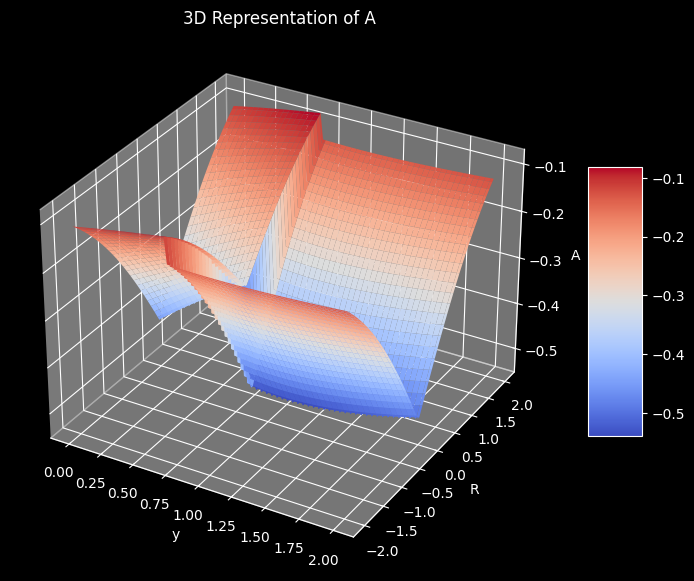

In [4]:
# Create grid for y and R (assuming these are the variables to vary)
y = np.linspace(0, 2, 100)
r = np.linspace(-2, 2, 100)
Y, R = np.meshgrid(y, r)

# Compute A
alpha = np.exp(-lambda1 * T - lambda2 * Y - lambda3 * np.abs(R))  # Using abs(R) for symmetry
gamma_hedge = 1 + gamma0 * Y * (Y > 0.7)
phi_decay = np.exp(phi0 * R**2)
A = alpha * gamma_hedge * phi_decay * sgn_term

# Plot 3D surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Y, R, A, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('y')
ax.set_ylabel('R')
ax.set_zlabel('A')
ax.set_title('3D Representation of A')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [5]:
# Part 2: Simulate the Backtest Graph
# Fetch S&P 500 data (using SPY ETF as proxy)
data = yf.download('SPY', start='2006-01-01', end='2014-01-10')  # Adjust end date as needed
close = data['Close']
returns = close.pct_change().dropna()
dates = returns.index

# Buy and Hold cumulative
bh_cum = (1 + returns).cumprod() * 100

# Regime detection using Markov Switching Model
model = MarkovRegression(returns, k_regimes=2, trend='c', switching_variance=True)
res = model.fit(disp=0)

# Identify bear regime (higher variance)
var0 = res.params['sigma2[0]']
var1 = res.params['sigma2[1]']
bear_regime = 1 if var1 > var0 else 0

# Smoothed probability of bear regime
smoothed_bear = res.smoothed_marginal_probabilities[bear_regime]

# Position: scale * probability of bull regime (adjust scale to approximate performance)
scale = 1.25  # Adjusted to get closer to +338% return
position = scale * (1 - smoothed_bear)

# Strategy returns
strategy_returns = position.shift(1) * returns  # Note: In practice, consider transaction costs
strat_cum = (1 + strategy_returns.fillna(0)).cumprod() * 100

/tmp/ipython-input-2086503931.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('SPY', start='2006-01-01', end='2014-01-10')  # Adjust end date as needed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
